# **Setup**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# **Load the data**

In [2]:
# Path to the data directory
data_dir = Path("Datasets\ColorCaptcha\\")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
print(images[:3])
print(labels[:3])

['Datasets\\ColorCaptcha\\111J8.jpg', 'Datasets\\ColorCaptcha\\111XM.jpg', 'Datasets\\ColorCaptcha\\113EV.jpg']
['111J8', '111XM', '113EV']


In [3]:
characters = set(char for label in labels for char in label)
print(characters)

{'B', 'W', '1', '4', 'E', 'D', 'Y', 's', '9', 'Z', 'c', 'g', 'b', 'f', 't', 'C', 'l', 'u', 'S', '3', 'a', 'i', 'I', 'R', 'm', '6', 'v', 'L', 'M', 'U', 'F', 'x', 'N', 'A', 'h', 'd', '5', 'j', 'G', 'X', 'k', 'e', 'p', 'H', '8', 'w', 'z', 'P', 'T', 'n', 'Q', 'V', 'r', 'q', '7', 'O', '2', 'J', 'K', 'y'}


In [4]:
characters = sorted(list(characters))
print(characters)

['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [5]:
print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of images found:  113062
Number of labels found:  113062
Number of unique characters:  60
Characters present:  ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [6]:
# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 128
img_height = 32

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])
print(max_length)

5


# **Preprocessing**

In [7]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [8]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

In [9]:
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

# **Create Datasets objects**

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [11]:
print(validation_dataset)

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 128, 32, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>


# **Visualize data**

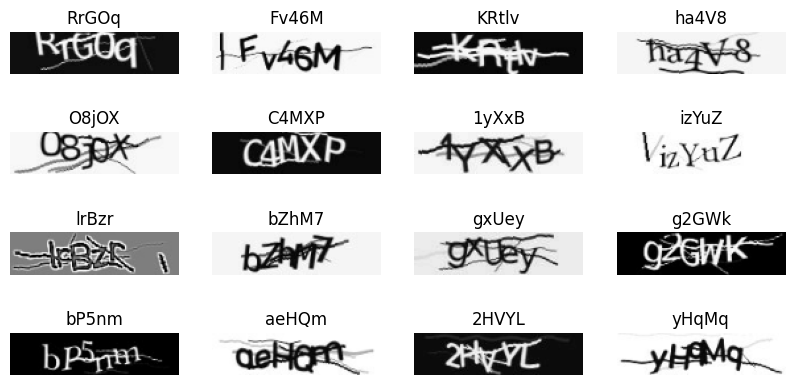

In [12]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

# **Model**

In [27]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    inputs = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    conv_1 = layers.Conv2D(32, (3,3), activation = "selu", padding='same')(inputs)
    pool_1 = layers.MaxPool2D(pool_size=(2, 2))(conv_1)
    
    conv_2 = layers.Conv2D(64, (3,3), activation = "selu", padding='same')(pool_1)
    pool_2 = layers.MaxPool2D(pool_size=(2, 2))(conv_2)
    print(pool_2.shape)
    

    squeezed = layers.Lambda(lambda x: keras.backend.squeeze(x, 1))(pool_2)
    
    # bidirectional LSTM layers with units=128
    blstm_1 = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(squeezed)
    blstm_2 = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(blstm_1)


    softmax_output = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation = 'softmax', name="dense")(blstm_2)
    print(softmax_output.shape)

    output = CTCLayer(name="ctc_loss")(labels, softmax_output)


    # Define the model
    model = keras.models.Model(
        inputs=[inputs, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    # Compile the model and return
    model.compile(optimizer=opt)
    return model

In [28]:
# Get the model
model = build_model()
model.summary()

(None, 32, 8, 64)


ValueError: Exception encountered when calling layer "lambda_6" (type Lambda).

Can not squeeze dim[1], expected a dimension of 1, got 32 for '{{node lambda_6/Squeeze}} = Squeeze[T=DT_FLOAT, squeeze_dims=[1]](Placeholder)' with input shapes: [?,32,8,64].

Call arguments received by layer "lambda_6" (type Lambda):
  • inputs=tf.Tensor(shape=(None, 32, 8, 64), dtype=float32)
  • mask=None
  • training=None

# **Training**

In [26]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
  82/6360 [..............................] - ETA: 31:39 - loss: inf

KeyboardInterrupt: 

# **Save model weights**

In [ ]:
model.save('ModelWeights\\UpdatedModel.h5')

# ***Load model***

In [ ]:
# Register the custom layer
keras.utils.get_custom_objects()["CTCLayer"] = CTCLayer

In [ ]:
# Load the model
loaded_model = keras.models.load_model('ModelWeights\\BaselineModel.h5')

In [ ]:
loaded_model.summary()

In [ ]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    loaded_model.get_layer(name="image").input, loaded_model.get_layer(name="dense2").output
)

In [ ]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()